this `hammer` module is install from rust binding with pyO3

check `rust` folder for more details

# Create mock data for Dark Matter Halo model

In [4]:
from matplotlib import pyplot as plt
import numpy as np
from hammer import dm 
from os.path import join, abspath, pardir
import sys
import vaex

In [8]:
root_dir = abspath(join(pardir,pardir))
root_dir

'/home2/s20321005/Thesis-Project'

In [9]:
if sys.path is not root_dir:
    sys.path.append(root_dir)
sys.path

['/home2/s20321005/Thesis-Project/6_mcmc/1_mock_dm',
 '/home2/s20321005/.conda/envs/vaex/lib/python38.zip',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/lib-dynload',
 '',
 '/home2/s20321005/.local/lib/python3.8/site-packages',
 '/home2/s20321005/.conda/envs/vaex/lib/python3.8/site-packages',
 '/home2/s20321005/Thesis-Project/6_mcmc',
 '/home2/s20321005/Thesis-Project']

In [10]:
from utils import concat, style

In [11]:
style()

In [12]:
root_data_dir = join(root_dir, 'Data')
root_data_dir

'/home2/s20321005/Thesis-Project/Data'

In [13]:
baryon_dir = join(root_data_dir, "Baryon")
baryon_dir

'/home2/s20321005/Thesis-Project/Data/Baryon'

In [14]:
# load baryons components
df_baryon = vaex.open(join(baryon_dir, "baryon.hdf5"))
df_baryon

#,components,rho,e_rho,sigma_z,e_sigma_z
0,Molecular gas (H2),0.0104,0.00312,3.7,0.2
1,Cold atomic gas (HI(1)),0.0277,0.00554,7.1,0.5
2,Warm atomic gas (HI(2)),0.0073,0.0007,22.1,2.4
3,Hot ionized gas (HII),0.0005,3e-05,39.0,4.0
4,Giant stars,0.0006,6e-05,15.5,1.6
...,...,...,...,...,...
7,4 < MV < 5,0.0029,0.00029,18.0,1.8
8,5 < MV < 8,0.0072,0.00072,18.5,1.9
9,MV > 8,0.0216,0.0028,18.5,4.0
10,White dwarfs,0.0056,0.001,20.0,5.0


## Math

from Poisson eq.
\begin{aligned}
  \nabla^2\Phi(z, r, \phi) = \frac{\partial^2 \Phi}{\partial z^2}+\frac{1}{r^2}\frac{\partial \Phi}{\partial \phi^2} + \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) = 4\pi G\rho
\end{aligned}

Assume axisymmetric potential, and can be decoupled
\begin{aligned}
  \Phi(z, r, \phi) =  \Phi(z, r) =  \Phi_z(z) + \Phi_r(r)
\end{aligned}

Therefore
\begin{aligned}
  \nabla^2\Phi(z, r, \phi)  = \frac{\partial^2 \Phi_z}{\partial z^2}+ \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) = 4\pi G\rho
\end{aligned}

where (Buch et. al. [2019](https://iopscience.iop.org/article/10.1088/1475-7516/2019/04/026))
\begin{aligned}
  \mathcal{R} &= \frac{1}{(4\pi G)} \frac{1}{r}\frac{\partial}{\partial r}\left(r\frac{\partial \Phi}{\partial r}\right) \\
    &= (3.4\pm 0.6)\times10^{-3} M_\odot /\text{pc}^3
\end{aligned}

and $\rho$ is divided into three parts
* Baryon, $\rho_i$
* Thin Dark Disk, $\rho_\text{DD}$
* Constant Local Halo Dark Matter $\rho_\text{DM}$


Using Bahcall Model for Baryon, for each components
\begin{aligned}
  \rho_i = \rho_{i,0}\exp{\left(-\frac{\Phi(z)}{\sigma_{z,i}}\right)}
\end{aligned}
And total baryons
\begin{aligned}
  \rho_b = \sum_i^N\rho_i
\end{aligned}

For thin DD
\begin{aligned}
  \rho_\text{DD}(z) = \frac{\Sigma_\text{DD}}{4h_\text{DD}}\text{sech}^2\left(\frac{z}{2h_\text{DD}}\right)
\end{aligned}

So,
\begin{aligned}
  \frac{\partial^2 \Phi_z}{\partial z^2} &= 4\pi G\rho_\text{eff} \\
  \frac{1}{4\pi G}\frac{\partial^2 \Phi_z}{\partial z^2} &= \sum_i^N\left[\rho_{i,0}\exp{\left(-\frac{\Phi(z)}{\sigma_{z,i}}\right)}\right] + \frac{\Sigma_\text{DD}}{4h_\text{DD}}\text{sech}^2\left(\frac{z}{2h_\text{DD}}\right) + \rho_\text{DM} - \mathcal{R}
\end{aligned}

All of this math has been baked into `hammer` module. Check out the `rust` folder for more details.

Example

In [15]:
# Baryonic density, check table 1 from this https://journals.aps.org/prl/pdf/10.1103/PhysRevLett.121.081101
rhob = df_baryon["rho"].to_numpy()  # Msun/pc^3
sigmaz = df_baryon["sigma_z"].to_numpy() # km/s
# dark matter density
rhoDM = 0.016

# normalisation of vertical density profile
log_nu0 = 0

# the rotation curve term
R = 3.4E-3

# the solar offset
zsun = 30

theta = concat(rhob, sigmaz, rhoDM, log_nu0, R, zsun)

# integration limits
z_start = 0
z_end = 200
theta.shape

(28,)

integrate using `mcmc.dm`

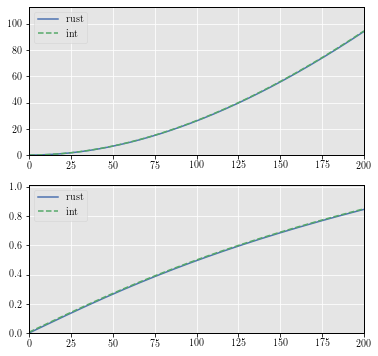

In [16]:
dz = 1
z, phi, Kz = dm.solve_potential(theta, z_start, z_end, dz)
u = np.array([phi, Kz])
dphi, dKz = dm.f(z, u, theta)
phi_int = np.cumsum(dphi)*dz
Kz_int = np.cumsum(dKz)*dz
# subplot
fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(z, phi, label=r"rust")
ax[0].plot(z, phi_int, label=r"int", ls="--")
# ax[0].set_xlabel(r"$z$ (pc)")
# ax[0].set_ylabel(r"$\phi$ (km/s)$^2$")
ax[0].set_xlim(0, z[-1])
ax[0].set_ylim(0, phi[-1]*1.2)
ax[0].legend()
ax[1].plot(z, Kz, label=r"rust")
ax[1].plot(z, Kz_int, label=r"int", ls="--")
# ax[1].set_xlabel(r"$z$ (pc)")
# ax[1].set_ylabel(r"$K_z$ [pc (km/s)$^2$]")
ax[1].set_xlim(0, z[-1])
ax[1].set_ylim(0, Kz[-1]*1.2)
ax[1].legend()
# plt.tight_layout()
plt.show()

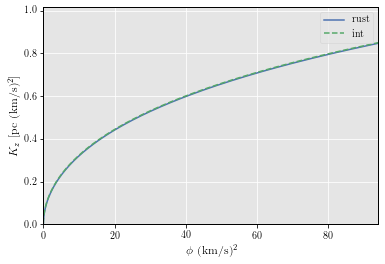

In [17]:
plt.plot(u[0], u[1], label=r"rust")
plt.plot(phi_int, Kz_int, label=r"int", ls="--")
plt.xlabel(r"$\phi$ (km/s)$^2$")
plt.ylabel(r"$K_z$ [pc (km/s)$^2$]")
plt.xlim(0, u[0][-1])
plt.ylim(0, u[1][-1]*1.2)
plt.legend()
plt.show()

Check the difference for different z interval

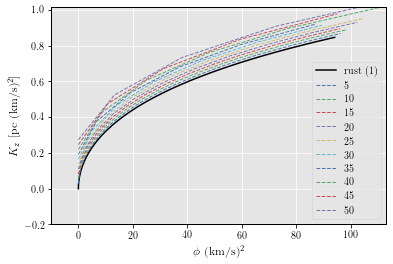

In [18]:
z, phi, Kz = dm.solve_potential(theta, z_start, z_end, 1)
plt.plot(phi, Kz, label=r"rust (1)", c='k')
for dz in range(5, 51, 5):
    z, phi, Kz = dm.solve_potential(theta, z_start, z_end, dz)
    u = np.array([phi, Kz])
    dphi, dKz = dm.f(z, u, theta)
    phi_int = np.cumsum(dphi)*dz
    Kz_int = np.cumsum(dKz)*dz
    plt.plot(phi_int, Kz_int, label=dz, ls="--", lw=1)
plt.xlabel(r"$\phi$ (km/s)$^2$")
plt.ylabel(r"$K_z$ [pc (km/s)$^2$]")
plt.xlim(-10, u[0][-1]*1.2)
plt.ylim(-0.2, u[1][-1]*1.2)
plt.legend()
plt.show()

the interval `z = 1` is the most accurate